In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import division
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../data/processed/icestupa_measurements.csv', parse_dates=['time'])
df.head()

,time,temp,rh,UV Index,pressure,picture_file,height_meters
0,2016-02-16 07:54:00,-6.06,35,1277,665.0,5.jpg,6.564907
1,2016-02-16 17:04:00,0.74,16,1308,663.0,6.jpg,6.661128
2,2016-02-18 17:07:00,7.56,4,1488,665.0,7.jpg,6.699651
3,2016-02-19 07:56:00,-4.87,20,1307,669.0,8.jpg,6.757407
4,2016-02-19 17:06:00,0.00,62,1285,666.0,9.jpg,6.795930


In [4]:
df['delta_time'] = (df['time']-df['time'].shift()).fillna(0)
df['delta_height'] = (df['height_meters']-df['height_meters'].shift()).fillna(0)

In [5]:
df['growth_rate'] = (df['delta_height']*100)/(df['delta_time'].apply(lambda x: x.total_seconds()/3600))

In [6]:
import datetime
from datetime import timedelta

In [7]:
dfdays = df[(df['delta_time']<timedelta(hours=18)) 
            & (df['delta_time']>timedelta(hours=0)) 
            & ((df.time.apply(lambda x: x.time())>datetime.time(12))==True)
            & (df['time']>=datetime.date(2016,3,1))]

In [8]:
dfnights = df[(df['delta_time']<timedelta(hours=18)) 
              & (df['delta_time']>timedelta(hours=0)) 
              & ((df.time.apply(lambda x: x.time())<datetime.time(12))==True)
              & (df['time']>=datetime.date(2016,3,1))]

In [9]:
import matplotlib.pyplot as plt

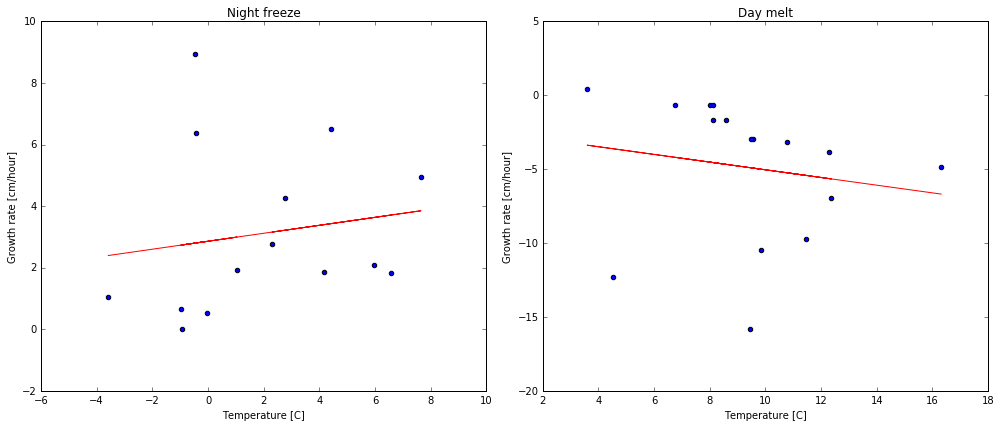

In [10]:
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(1,2,1)
dfnights.plot(x='temp', y='growth_rate', kind='scatter', title='Night freeze', ax=ax);
# add regression line
plt.plot(dfnights['temp'], np.poly1d(np.polyfit(dfnights['temp'], dfnights['growth_rate'], 1))(dfnights['temp']),
         color='r')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Growth rate [cm/hour]')
ax=fig.add_subplot(1,2,2)
dfdays.plot(x='temp', y='growth_rate', kind='scatter', title='Day melt', ax=ax);
plt.plot(dfdays['temp'], np.poly1d(np.polyfit(dfdays['temp'], dfdays['growth_rate'], 1))(dfdays['temp']),
         color='r')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Growth rate [cm/hour]')
fig.tight_layout()
plt.show();

The picture here is too simplistic: rather than linking the average growth rate in a period (day/night) to the instantaneous temperature, we should view it as a function of the average temperature over the last (say) 12 hours. The corresponding data can be retrieved from the Bloomsky data set.

In [11]:
dfb = pd.read_csv('../data/processed/bloomsky_data.csv', parse_dates=['time'])
dfb.set_index('time', inplace=True)
dfb.head()

,temp,rh,uv,pressure
time,,,,
2016-02-11 19:34:00,-3.91,55,1249,654.0
2016-02-11 19:39:00,-3.97,55,1249,654.0
2016-02-11 19:44:00,-4.07,56,1248,654.0
2016-02-11 19:49:00,-4.09,56,1249,654.0
2016-02-11 19:54:00,-4.15,55,1249,654.0


In [12]:
print('Bloomsky DataFrame contains %d records' % len(dfb))
print('Bloomsky DataFrame contains %d records if we exclude NA values' % len(dfb.dropna()))
print('Bloomsky DataFrame contains %d records if we exclude NA values for all columns except pressure' %
      len(dfb[[col for col in dfb.columns if col != 'pressure']].dropna()))

Bloomsky DataFrame contains 9742 records
Bloomsky DataFrame contains 5752 records if we exclude NA values
Bloomsky DataFrame contains 9742 records if we exclude NA values for all columns except pressure


The pressure columns contains too many missing/invalid values, we won't consider it for analysis

In [13]:
df = df[['time', 'height_meters', 'growth_rate']].copy()

In [14]:
from datetime import timedelta

Adding average temperature, humidity and UV values over the past 12 hours

In [15]:
df['temp_12h_avg'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].mean())
df['temp_12h_count'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].count())

df['rh_12h_avg'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].mean())
df['rh_12h_count'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].count())

df['uv_12h_avg'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['uv'].mean())
df['uv_12h_count'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['uv'].count())

Filtering records for which averages are calculated over less than 5 values over the past 12 hours

In [16]:
df = df[(df[[col for col in df.columns if col.endswith('count')]]>=5).all(axis='columns')]
df = df[[col for col in df.columns if not col.endswith('count')]]

In [17]:
df['type'] = df['time'].apply(lambda x: 'AM' if x.time()<datetime.time(12) else 'PM')

Final cleaning

In [18]:
df.dropna(inplace=True)

#### Correlation/linear regression plots

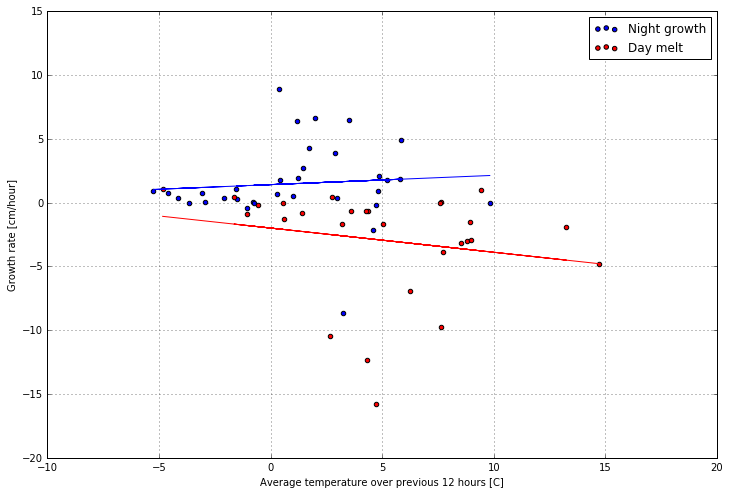

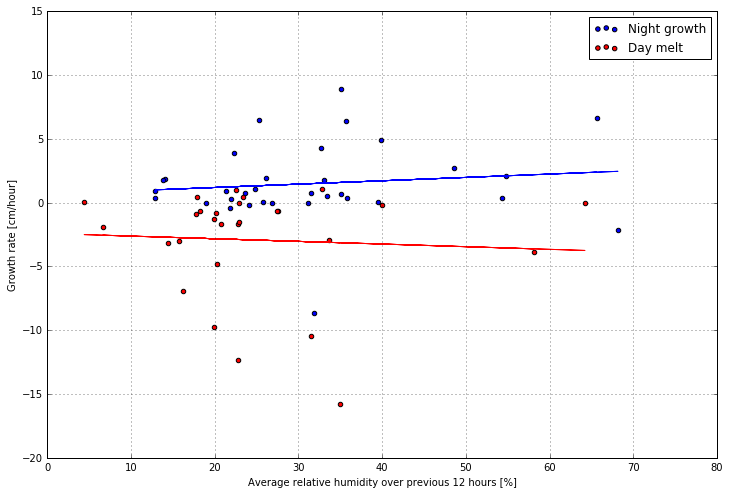

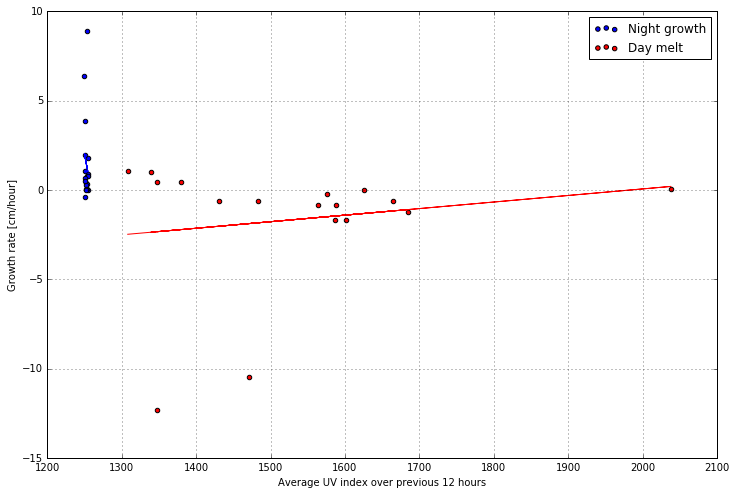

In [19]:
var_dict = {'temp_12h_avg': 'Average temperature over previous 12 hours [C]',
            'uv_12h_avg': 'Average UV index over previous 12 hours',
            'rh_12h_avg': 'Average relative humidity over previous 12 hours [%]'}
for var in var_dict:
    fig=plt.figure(figsize=(12,8))
    ax=fig.add_subplot(1,1,1)
    for mtype in [('AM', 'Night growth', 'b'), ('PM', 'Day melt', 'r')]:
        dftmp = df[df['type']==mtype[0]]
        if var == 'uv_12h_avg':
            dftmp = dftmp[dftmp[var]>100] # filtering erroneously low values
        dftmp.plot(x=var, y='growth_rate', kind='scatter', ax=ax, label=mtype[1], color=mtype[2])
        plt.plot(dftmp[var], np.poly1d(np.polyfit(dftmp[var], dftmp['growth_rate'], 1))(dftmp[var]),
                 color=mtype[2])
    plt.grid()
    ax.set_xlabel(var_dict[var])
    ax.set_ylabel('Growth rate [cm/hour]')
    plt.show();

### Multivariate linear regression

We want to know how the growth rate depends on the predictors we measured, and to what extent a linear combination of these predictors alone can explain the observed growth rate.

We will use elastic net regularisation, which has the advantage of doing feature selection and accounting for collinearity between predictors. This allows us to add new features to the model selection workflow and select the relevant ones.

In [20]:
print('%d morning measurements' % len(df[df['type']=='AM']))
print('%d evening measurements' % len(df[df['type']=='PM']))

33 morning measurements
28 evening measurements


We will model separately the growth and the melt process, as they have different dynamics and depend on different parameters. In addition, our data set is so small that it won't make sense to do cross-validation; we are not interested in prediction anyway (just description), so there's nothing wrong with scoring (testing) on the training set.

In [21]:
from sklearn.linear_model import ElasticNet
model = ElasticNet()

In [22]:
X = df[df['type']=='AM'][['temp_12h_avg', 'rh_12h_avg', 'uv_12h_avg']]
y = df[df['type']=='AM']['growth_rate']
model.fit(X,y)
print('Morning observations: R-squared = %0.2f' % model.score(X,y))

X = -df[df['type']=='PM'][['temp_12h_avg', 'rh_12h_avg', 'uv_12h_avg']] # we model negative growth rate (melt)
y = df[df['type']=='PM']['growth_rate']
model.fit(X,y)
print('Evening observations: R-squared = %0.2f' % model.score(X,y))

Morning observations: R-squared = 0.03
Evening observations: R-squared = 0.16


Rather poor performance in both cases -- let's add additional features created from the same time series

In [23]:
df['temp_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].min())
df['temp_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].max())
df['temp_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].std())

df['rh_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].min())
df['rh_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].max())
df['rh_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].std())

df['uv_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['uv'].min())
df['uv_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['uv'].max())
df['uv_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['uv'].std())

In [26]:
model_am = ElasticNet()
model_pm = ElasticNet()
X_am = df[df['type']=='AM'][[col for col in df.columns if (col.startswith('temp')
                                                           or col.startswith('rh')
                                                           or col.startswith('uv')
                                                          )]]
y_am = df[df['type']=='AM']['growth_rate']
model_am.fit(X_am,y_am)
print('Morning observations: R-squared = %0.2f' % model_am.score(X_am,y_am))

X_pm = -df[df['type']=='PM'][[col for col in df.columns if (col.startswith('temp')
                                                            or col.startswith('rh')
                                                            or col.startswith('uv')
                                                           )]]
y_pm = df[df['type']=='PM']['growth_rate']
model_pm.fit(X_pm,y_pm)
print('Morning observations: R-squared = %0.2f' % model_pm.score(X_pm,y_pm))

Morning observations: R-squared = 0.07
Morning observations: R-squared = 0.27


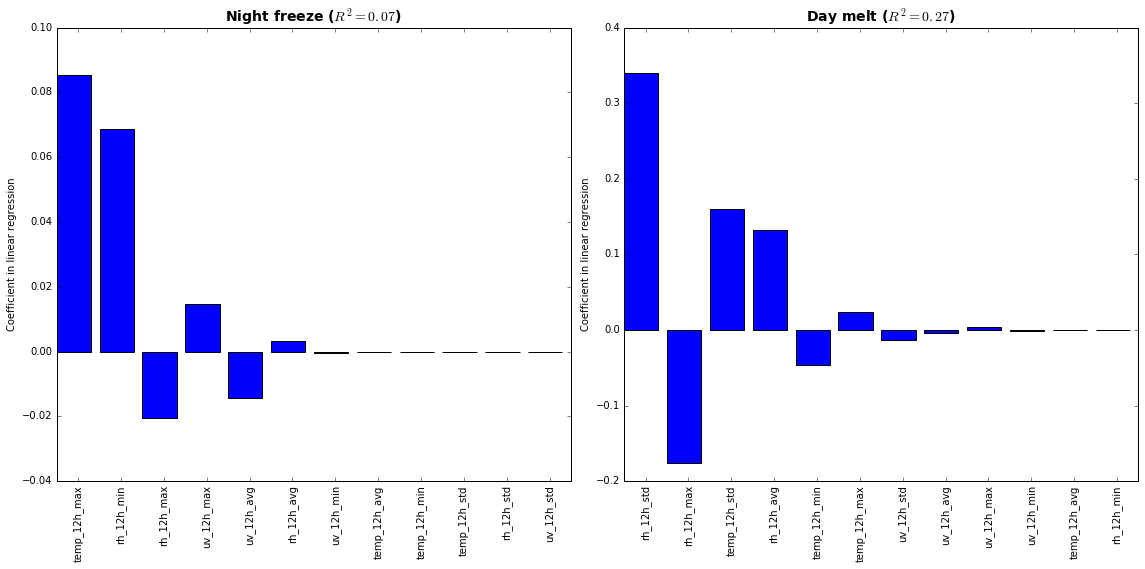

In [25]:
fig=plt.figure(figsize=(16,8))

# getting unzipped lists of feature names and corresponding coefficients, sorted by absolute decreasing coefficient
features_am, weights_am = zip(*sorted(zip(X_am.columns, model_am.coef_), key=lambda x: abs(x[1]), reverse=True))
features_pm, weights_pm = zip(*sorted(zip(X_pm.columns, model_pm.coef_), key=lambda x: abs(x[1]), reverse=True))

ax=fig.add_subplot(1,2,1)
plt.bar(range(len(weights_am)), weights_am)
ax.set_ylabel('Coefficient in linear regression')
plt.xticks([x+0.5 for x in range(len(weights_am))], features_am, rotation='vertical')
ax.set_title('Night freeze ($R^2=%0.2f$)' % model_am.score(X_am,y_am), {'fontsize': 14, 'fontweight' : 'bold'})

ax=fig.add_subplot(1,2,2)
plt.bar(range(len(weights_pm)), weights_pm)
ax.set_ylabel('Coefficient in linear regression')
plt.xticks([x+0.5 for x in range(len(weights_pm))], features_pm, rotation='vertical')
ax.set_title('Day melt ($R^2=%0.2f$)' % model_pm.score(X_pm,y_pm), {'fontsize': 14, 'fontweight' : 'bold'}) 

plt.tight_layout()
plt.show()

#### Model interpretation

For both phenomena (freeze and melt), the regression quality is poor to moderate.

In the case of the night freeze, we observe that, surprisingly, high temperatures lead to high growth rates. It is possible that a latent factor (e.g., flow increased due to high enough temperature) is ignored here. The second most important feature is the relative humidity, which needs to be kept sufficiently high (the minimum level is determinant) to ensure good freeze. Other features are comparatively less significant.

In the case of the day melt, the fit of the model is comparatively much better ($R^2=0.27$); note that we're modelling the negative growth rate (melt rate). Much of the model's descriptive power seems to be linked to a high estimated weight of the variation in humidity over the course of the day: the more the relative humidity varies, the faster the ice stupa melts. The relationship is not trivial, and may underline the effect of a latent, unobserved variable. The same applies for the second variable, the maximum observed relative humidity level. More interesting is the third largest factor: large temperature variations over the course of the day seem to be linked to high melt rates, which may indicate that temperature fluctuations lead to structural fragilisation of the ice stupa.

Overall, our models suffer from a lack of data, and a lack of meaningful data. Not only the observation data sets are very small for both phenomena, but they lack a crucial 3-week period (cf. data import/cleaning notebook) during which the stupa grows to its maximum weights, and then start melting.